In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import sys, glob, os, imageio
import numpy as np
import matplotlib.pyplot as plt
import torch
import helper.canon_supervised_dataset as dset
import helper.post_processing as pp
import helper.utils as ut
import matplotlib
import helper.gan_helper_fun as gh
from skimage import exposure
matplotlib.rcParams.update({'font.size': 22})

# View synthetic noise
In this notebook, we load in our pretrained noise model, and show our synthetic noise vs. real noise from our camera.

## Load in saved model

In [2]:
device = 'cuda:0'
gpu = 0
base_folder = 'C:\projects\saved_models'
chkp_name ='noisemodelUnet_shot_read_uniform_row1_rowt_fixed1_periodic_learnedfixed_256_semidark_fourier_yournamehere'
generator = gh.load_from_checkpoint_ab(os.path.join(base_folder, chkp_name), gpu).to(device)
generator.keep_track = True

generator device 0
using learned fixed noise
distributed
current epoch 280


In [3]:
os.path.basename(os.path.join(base_folder, chkp_name))

'noisemodelUnet_shot_read_uniform_row1_rowt_fixed1_periodic_learnedfixed_256_semidark_fourier_yournamehere'

## Load in image 

In [4]:
#options: gan_gray, gan_color, natural 
dataset_arg = 'semidark'
# Change this filepath to point to your downloaded data directory:
filepath_data = 'C:/projects/starlight_denoising/data/'
dataset_list_test = dset.get_dataset_noise_visualization(dataset_arg, filepath_data)

In [70]:
test_loader = torch.utils.data.DataLoader(dataset=dataset_list_test, 
                                           batch_size=1,
                                           shuffle=False) 

In [71]:
len(dataset_list_test)

4

In [76]:
sample = dataset_list_test.__getitem__(1)

In [77]:
for key in sample:
    print(key, sample[key].shape)

noisy_input torch.Size([4, 16, 512, 830])
gt_label_nobias torch.Size([4, 16, 512, 830])


In [78]:
# clean_raw.shape

# d = {'key': clean_raw}
# # dset.RandCrop_gen_lowlightcams()(clean_raw).shape
# dset.FixedCrop_gen(shape=(256, 256))(d)['key'].shape

In [79]:
with torch.no_grad():
    sample = dset.RandCrop_gen(shape=(256, 256))(sample)
    clean_raw = gh.t32(sample['gt_label_nobias'].unsqueeze(0).to(device))
    real_noisy = sample['noisy_input'].cpu().detach().numpy().transpose(1,2,3,0)
    clean_patch = sample['gt_label_nobias'].cpu().detach().numpy().transpose(1,2,3,0)
    
    generator.indices = [10,10]
    gen_noisy = generator(clean_raw, False)
    gen_noisy_np = gen_noisy.cpu().detach().numpy().transpose(0,2,3,1)

In [80]:
print(gen_noisy_np.shape)
print(clean_patch.shape)
print(real_noisy.shape)

(16, 256, 256, 4)
(16, 256, 256, 4)
(16, 256, 256, 4)


In [81]:
clean_patch[0, :, :, 0]
clean_patch[2, :, :, 0].max(), clean_patch[0, :, :, 0].min()

(0.9147059, 0.04098039)

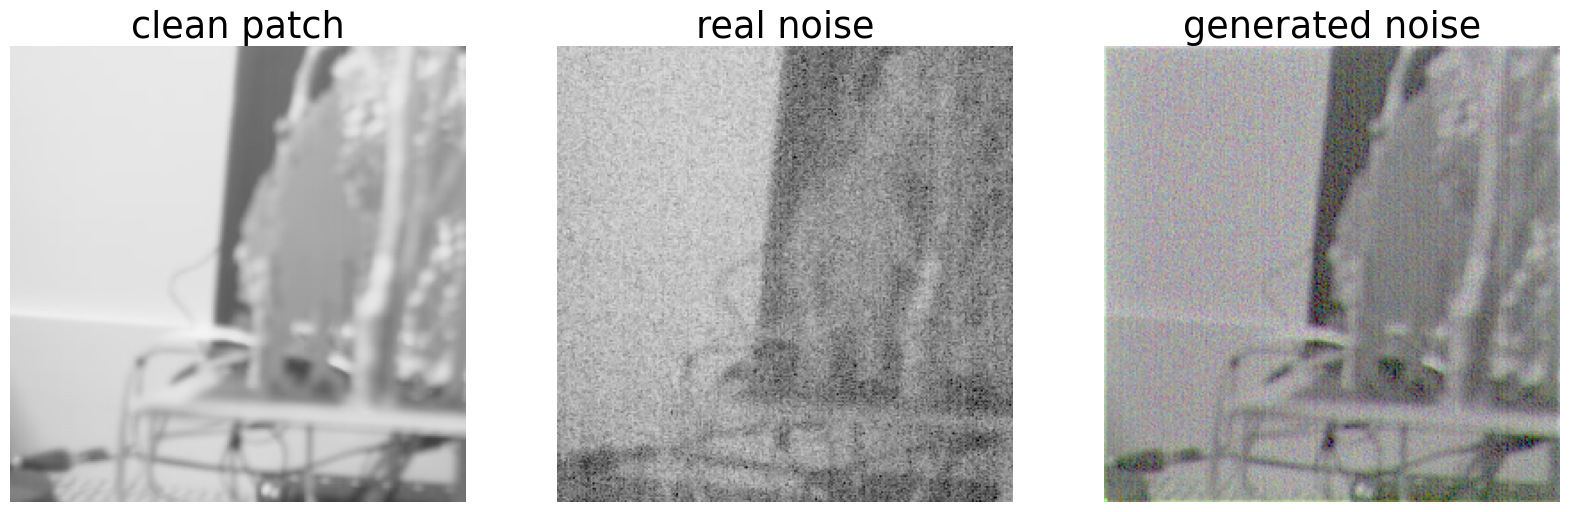

In [82]:
ind = 0
sz = 256
pp = [0,0]

to_plot = [clean_patch[ind], real_noisy[ind], gen_noisy_np[ind]]
titles = ['clean patch', 'real noise', 'generated noise']

fig, ax = plt.subplots(1,3, figsize = (20,10))
for i in range(0,3):
    ax[i].imshow(to_plot[i][pp[0]:pp[0]+sz,pp[1]:pp[1]+sz,0:3]**(1/2.2)); 
    ax[i].axis('off');
    ax[i].set_title(titles[i]);


## View each noise component separately

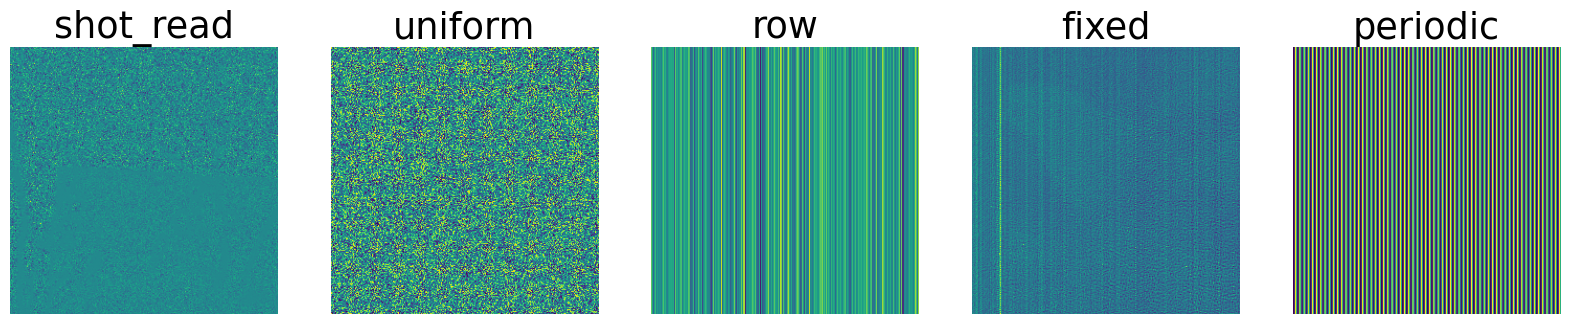

In [60]:
c = 0
all_noise_comps = list(generator.all_noise.keys())
fig, ax = plt.subplots(1,len(all_noise_comps), figsize = (20,10))
for i in range(0,len(all_noise_comps)):
        noise_curr = generator.all_noise[all_noise_comps[i]][0].transpose(1,2,0)[...,0:3]
        ax[i].imshow(noise_curr[...,c])
        ax[i].set_title(all_noise_comps[i])
        ax[i].axis('off')